Classification or Regression?(input 'c' or 'r')r


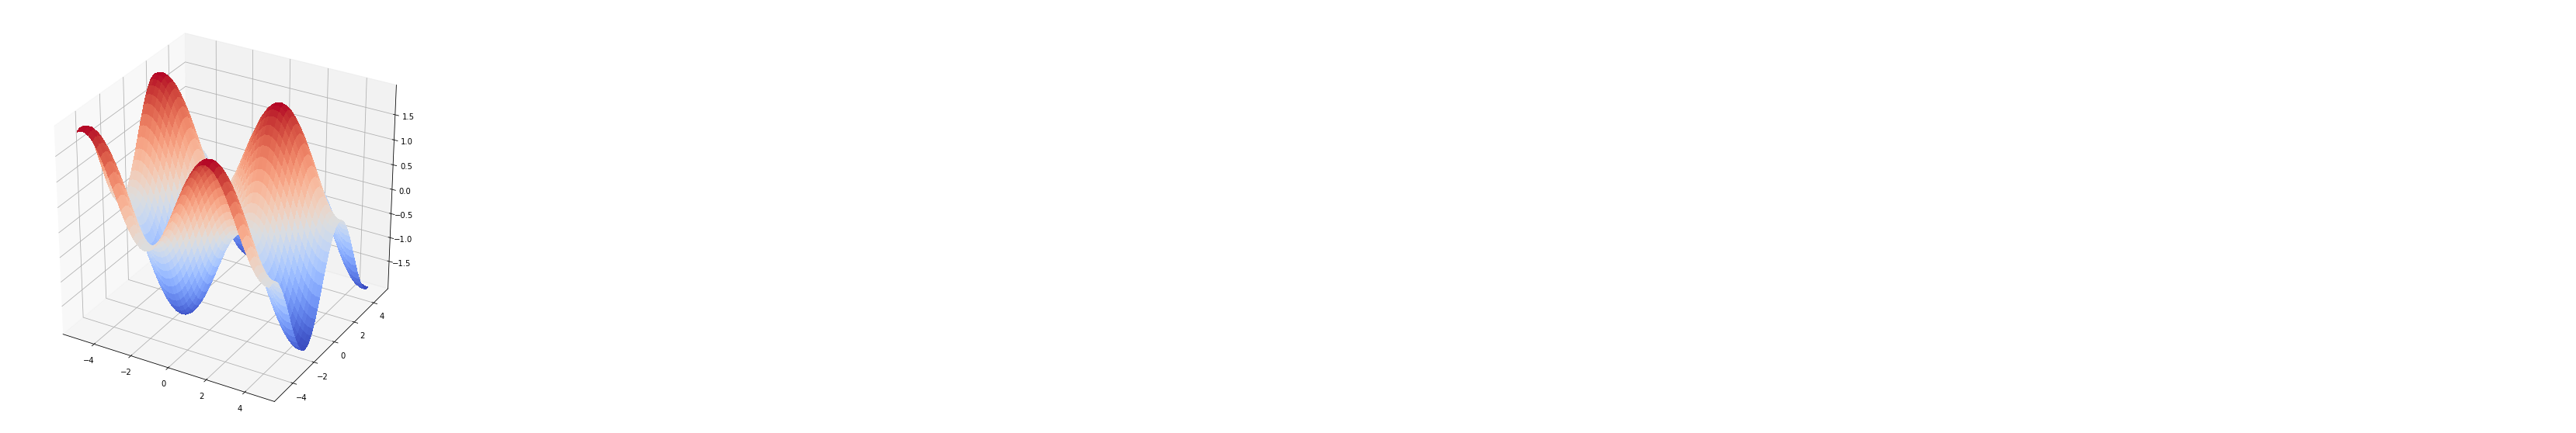

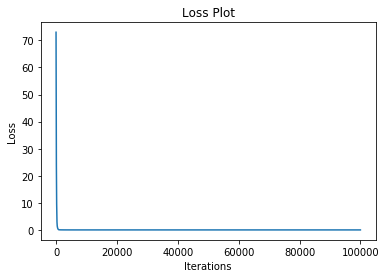

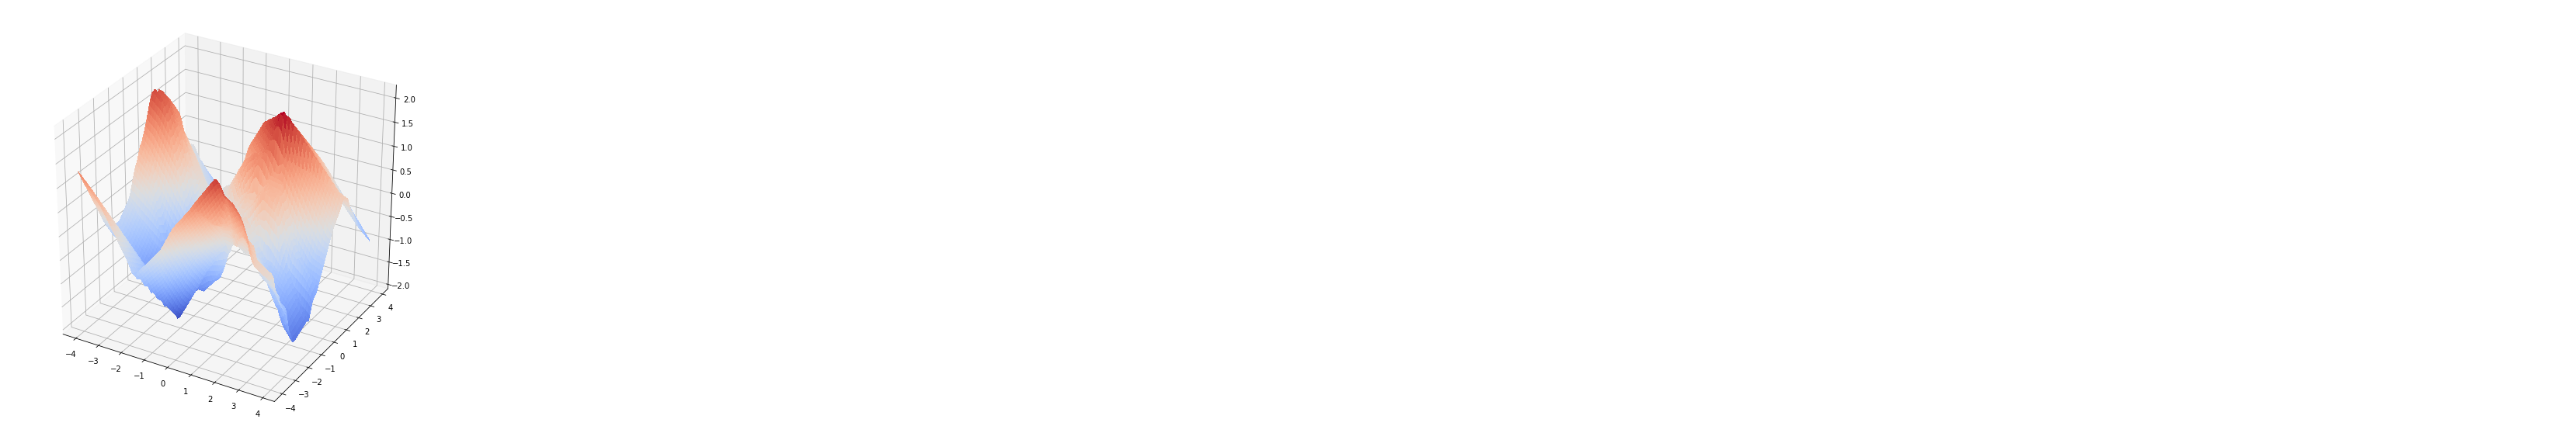

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from pdb import set_trace

random.seed(0)

class net:
    def __init__(self, inputdata, outputdata, size, ss, numofiter, dim, hiddenlayerlist, modeltype):
        self.input = inputdata
        self.output = outputdata
        self.size = size
        self.ss = ss
        self.iter = numofiter
        self.dim = dim
        self.nd = len(hiddenlayerlist[0])
        self.modeltype = modeltype

        self.loss = []
        self.hiddenunits = hiddenlayerlist
        
        #randomly generate the weights and biases based on the layers and units
        wb = []
        wb.append(np.random.rand(dim + 1, self.hiddenunits[0][0]) * 2 - 1)
        if (self.nd > 1):
            for i in range(1,self.nd):
                wb.append(np.random.rand(self.hiddenunits[0][i - 1] + 1, self.hiddenunits[0][i]) * 2 - 1)
        
        wb.append(np.random.rand(self.hiddenunits[0][-1] + 1, 1) * 2 - 1)
        self.wb = wb
    
    #only forward to get the result
    def forwardewithcomputedW(self, testx):
        ones = np.ones((np.shape(testx)[0], 1))
        
        newinput = np.append(testx, ones, axis=1)
        
        z = np.dot(newinput, self.wb[0])
        a = np.maximum(z, 0)
        
        for i in range(1, self.nd):
            a = np.append(a, ones, axis=1)
            z = np.dot(a, self.wb[i])
            a = np.maximum(z, 0)
        
        a = np.append(a, ones, axis=1)
        z = np.dot(a, self.wb[-1])
        if self.modeltype == "c":
            a = sigmoid(z)
            a[a > 0.5] = 1
            a[a <= 0.5] = 0
        else:
            a = z
        
        return a
        
    #forward and backward to train the network
    def backpropagation(self):
        ones = np.ones((self.size, 1))
        
        for e in range(self.iter):
            #forward
            #two lists to store a and z
            alist = [self.input]
            newinput = np.append(self.input, ones, axis=1)
            zlist = []
            
            z = np.dot(newinput, self.wb[0])
            a = np.maximum(z, 0)
            alist.append(a)
            zlist.append(z)
            
            for i in range(1, self.nd):
                a = np.append(a, ones, axis=1)
                z = np.dot(a, self.wb[i])
                zlist.append(z)
                a = np.maximum(z, 0)
                alist.append(a)
        
            a = np.append(a, ones, axis=1)
            z = np.dot(a, self.wb[-1])
            
            zlist.append(z)
            
            if self.modeltype == "c":
                a = sigmoid(z)
                a = checkzero(a)
                alist.append(a)
                #modified loss(classification)
                self.loss.append((-1) * np.mean(((1 - self.output) * np.log(1 - alist[-1])) + self.output * np.log(alist[-1])))
                outputerror = ((1 - self.output)/(1 - alist[-1]) - self.output / alist[-1]) * sigmoidD(zlist[-1])
            else:
                #loss(Regression)
                alist.append(a)
                self.loss.append( np.mean(0.5 * np.square(self.output - zlist[-1]), axis=0))
                outputerror = (zlist[-1] - self.output)
            
            
            #backward
            errorlist = [outputerror]
            for j in range(1, self.nd + 1):
                
                tempW = np.delete(np.transpose(self.wb[-j]), -1, axis=1)
                error = np.multiply(np.dot(errorlist[-j], tempW), ReluD(zlist[-j - 1]))
                errorlist = [error] + errorlist
            
            ########################## Rrop+ algorithm begin ##########################
            #update W and b in Rprop algorithm
            npos, nneg = 1.2, 0.5
            dmax, dmin = 50.0, 0.000001
            initial_d = 0.0001

            # grad[k][i][j] means the kth layer, the gradient of w_ij
            # prevgrad means the previous gradient
            # d means the delta in the learning rule, it is always > 0
            # dw is d * sign(gradient)
            grad, prevgrad, d, dw = [], [], [], []
            for k in range(0, len(self.wb)):
                # np.shape(self.wb[k])[0] - 1, because the last row of self.wb[k] is bias, we only update weights
                grad.append( np.zeros((np.shape(self.wb[k])[0] - 1, np.shape(self.wb[k])[1])) )
                prevgrad.append( np.zeros(np.shape(grad[k])) )
                dw.append( np.zeros(np.shape(grad[k])) )
                d.append( np.ones(np.shape(grad[k])) * initial_d )
            
            for k in range(0, len(self.wb)):
                grad[k] = np.dot(np.transpose(alist[k]), errorlist[k])
                prev_grad_multiply_grad = prevgrad[k] * grad[k]
                
                gt_index = prev_grad_multiply_grad > 0
                lt_index = prev_grad_multiply_grad < 0
                eq_index = prev_grad_multiply_grad == 0
                
                ## prev_grad * grad > 0 ##
                d[k][gt_index] = np.minimum(d[k][gt_index] * npos, dmax)
                dw[k][gt_index] = d[k][gt_index] * np.sign(grad[k][gt_index])
                
                ## prev_grad * grad < 0 ##
                d[k][lt_index] = np.maximum(d[k][lt_index] * nneg, dmin)
                grad[k][lt_index] = 0

                ## prev_grad * grad == 0 ##
                dw[k][eq_index] = d[k][eq_index] * np.sign(grad[k][eq_index])
                
                self.wb[k][0:-1, :] = self.wb[k][0:-1, :] - dw[k]
                self.wb[k][-1, :] = self.wb[k][-1, :] - self.ss * np.mean(errorlist[k], axis=0) / self.size
                
                prevgrad[k] = grad[k]
            ########################## Rrop+ algorithm end ##########################
        
        #plot the Loss
        plt.figure(3)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss Plot')
        plt.plot(range(1, self.iter + 1), self.loss)
        plt.show()

def generatedata(size, dim, margin):
    size = int(size)
    ones = np.ones((size // 2, 1))
    zeros = np.zeros((size // 2, 1))
    
    #check margin here, if not zero, use margin to make data separable, if it is zero, make it not separable
    if margin != 0:
        if dim == 1:
            x1 = np.random.rand(size // 2, 1) * 3 + margin / 2
            x2 = np.random.rand(size // 2, 1) *(-3) - margin / 2
            x = np.vstack((x1, x2))
            y = np.vstack((ones, zeros))
        
        elif dim == 2:
            s1 = np.random.rand(size // 2, 1) * 2 + margin / 2 
            s2 = np.random.rand(size // 2, 1) * (-2) - margin / 2
            x1 = np.random.rand(size, 1) * 4 - 2
            coff = np.random.rand(1, 1) * 4 -2
            b = np.reshape(np.random.random(1) * 4 - 2, (1, 1))
            x2 = np.dot(x1, coff)+ np.asscalar(b) + np.vstack((s1, s2))
            x = np.append(x1, x2, axis=1)
            s1.fill(1)
            s2.fill(0)
            y = np.vstack((s1, s2))
    else:
        if dim == 1:
            x1 = np.random.rand(size // 4, 1) + 1
            x2 = np.random.rand(size // 4, 1) * (-1)
            x3 = np.random.rand(size // 4, 1)
            x4 = np.random.rand(size // 4, 1) * (-1) - 1
            
            x = np.vstack((np.vstack((np.vstack((x1, x2)), x3)), x4))
            y = np.vstack((ones, zeros))
        
        elif dim == 2:
            x1 = np.random.rand(size, 1) * 8 - 4
            s1 = np.random.rand(size // 2, 1) * 2
            s2 = np.random.rand(size // 2, 1) * (-2)
            x2 = np.reshape(3 * np.sum(np.sin(x1), axis=1), (size, 1)) + np.vstack((s1, s2))
            x = np.append(x1, x2, axis=1)
            s1.fill(1)
            s2.fill(0)
            y = np.vstack((s1, s2))
    
    return x, y

def generatedataForRegression(size,dim):
    if dim == 1:
        x =np.reshape(np.linspace(-math.pi, math.pi, num=size), (size, dim))
    else:
        #x = np.random.rand(size,dim)*10 -5
        X = np.arange(-5, 5, 0.2)
        Y = np.arange(-5, 5, 0.2)
        X, Y = np.meshgrid(X, Y)
        a = X.flatten()
        b = Y.flatten()
        x = np.append(np.reshape(a,(len(a),1)), np.reshape(b,(len(b),1)), axis=1)
        size = 2500
    
    y = np.reshape(np.sum(np.sin(x), axis=1), (size,1))
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    out = np.reshape(y, np.shape(X))
    ax.plot_surface(X, Y, out,rstride=1, cstride=1,cmap=cm.coolwarm, linewidth=0, antialiased=False)
    return x, y 




def ReluD(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x

def checkzero(x):
    x[x == 0] = 1e-16
    x[x == 1] = 1 - 1e-16
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoidD(x):
    """Derivative of the sigmoid function."""
    return sigmoid(x) - np.multiply(sigmoid(x), sigmoid(x))


def main():
    #set hyperparameter at here 
    hiddenlayerlist = [[16,32,16]]    #change the number of hidden layer, and nodes in the layer
    
    ss = 1e-4           #step Size
    numofiter = 100000   #iterations
    size = 2500          #input size
    dim = 2             #input dimension
    margin = 0          #change Margin at here, change this value to 0 to make the data not linear separable
    
    modeltype = input("Classification or Regression?(input 'c' or 'r')")
    
    
    if modeltype == "c":
        
        #generate the input and output for classification
        inputdata, outputdata = generatedata(size, dim, margin)

        #plot to viaualize if it is 1D
        print("Training Data Plot: ")
        plt.figure(1)
        if dim == 1:
            
            plt.scatter(inputdata[: size // 2, 0],np.ones((size // 2, 1)), color="r")
            plt.scatter(inputdata[size // 2 :, 0],np.ones((size // 2, 1)), color="b")
            plt.legend(['Label 1', 'Label 0'], loc='upper right')
        elif dim == 2:
        
            plt.scatter(inputdata[: size // 2, 0],inputdata[: size // 2, 1], color="r")
            plt.scatter(inputdata[size // 2 :, 0],inputdata[size // 2 :, 1], color="b")
            plt.legend(['Label 1', 'Label 0'], loc='upper right')
    
        network = net(inputdata, outputdata, size, ss, numofiter, dim, hiddenlayerlist, modeltype)
        network.backpropagation()
        output = network.forwardewithcomputedW(inputdata)
    
        #plot network computed result
        output = np.append(inputdata,output, axis=1)
        print("Network computed output: ")
    
        plt.figure(4)
        if dim ==1:
        
            output1 = output[output[:, -1] == 1]
            output2 = output[output[:, -1] == 0]
            plt.scatter(output1[:, 0],np.ones((np.shape(output1)[0], 1)), color="r")
            plt.scatter(output2[:, 0],np.ones((np.shape(output2)[0], 1)), color="b")
            plt.legend(['Label 1', 'Label 0'], loc='upper right')
        
        if dim ==2:
            output1 = output[output[:, -1] == 1]
            output2 = output[output[:, -1] == 0]
            plt.scatter(output1[:, 0], output1[:, 1], color="r")
            plt.scatter(output2[:, 0], output2[:, 1], color="b")
            plt.legend(['Label 1', 'Label 0'], loc='upper right')
    
        plt.show()
    
    elif modeltype == "r":
        #generate the input and output for regression
        inputdata, outputdata = generatedataForRegression(size,dim)
        network = net(inputdata, outputdata, size, ss, numofiter,dim, hiddenlayerlist, modeltype)
        network.backpropagation()
        if dim == 2:
            fig = plt.figure(figsize=(10,10))
            ax = plt.axes(projection='3d')
            X = np.arange(-4, 4, 0.1)
            Y = np.arange(-4, 4, 0.1)
            X, Y = np.meshgrid(X, Y)
            a = X.flatten()
            b = Y.flatten()
            testx = np.append(np.reshape(a,(len(a),1)), np.reshape(b,(len(b),1)), axis=1)
            outputy = np.reshape(network.forwardewithcomputedW(testx), np.shape(X))     
            ax.plot_surface(X, Y, outputy,rstride=1, cstride=1,cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
    


if __name__ == '__main__':
    main()